Classifying text with TensorFlow Estimators
===

This notebook demonstrates how to tackle a text classification problem using custom TensorFlow estimators, embeddings and the [tf.layers](https://www.tensorflow.org/api_docs/python/tf/layers) module. Along the way we'll learn about word2vec and transfer learning as a technique to bootstrap model performance when labeled data is a scarce resource.

## Setup

Let's begin importing the libraries we'll need. This notebook runs in Python 3 and TensorFlow v1.4 or more, but it can run in earlier versions of TensorFlow by replacing some of the import statements to the corresponding paths inside the `contrib` module.

### The IMDB Dataset

The dataset we wil be using is the IMDB [Large Movie Review Dataset](http://ai.stanford.edu/~amaas/data/sentiment/), which consists of $25,000$ highly polar movie reviews for training, and $25,000$ for testing. We will use this dataset to train a binary classifiation model, able to predict whether a review is positive or negative.

In [1]:
import os
import string
import tempfile
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

from tensorflow.python.keras.datasets import imdb
from tensorflow.python.keras.preprocessing import sequence
from tensorboard import summary as summary_lib

tf.logging.set_verbosity(tf.logging.INFO)
print(tf.__version__)

1.6.0-rc1


### Loading the data

Keras provides a convenient handler for importing the dataset which is also available as a serialized numpy array `.npz` file to download [here]( https://s3.amazonaws.com/text-datasets/imdb.npz). Each review consists of a series of word indexes that go from $4$ (the most frequent word in the dataset, **the**) to $4999$, which corresponds to **orange**. Index $1$ represents the beginning of the sentence and the index $2$ is assigned to all unknown (also known as *out-of-vocabulary* or *OOV*) tokens. These indexes have been obtained by pre-processing the text data in a pipeline that cleans, normalizes and tokenizes each sentence first and then builds a dictionary indexing each of the tokens by frequency. We are not convering these techniques in this post, but you can take a look at [this chapter](http://www.nltk.org/book/ch03.html) of the NLTK book to learn more.

It's standard to limit the size of the vocabulary to prevent the dataset from becoming too sparse and high dimensional, causing potential overfitting. After we've loaded the data in memory we pad each of the sentences with $-1$ to a fixed size (here: $200$) so that we have two $2$-dimensional $25000\times200$ arrays for training and testing respectively.



In [2]:
vocab_size = 5000
sentence_size = 200
embedding_size = 50
model_dir = tempfile.mkdtemp()

# Should we not use keras and rewrite this logic?
print("Loading data...")
(x_train_variable, y_train), (x_test_variable, y_test) = imdb.load_data(
    num_words=vocab_size)
print(len(y_train), "train sequences")
print(len(y_test), "test sequences")

print("Pad sequences (samples x time)")
x_train = sequence.pad_sequences(x_train_variable, 
                                 maxlen=sentence_size, 
                                 padding='post', 
                                 value=-1)
x_test = sequence.pad_sequences(x_test_variable, 
                                maxlen=sentence_size, 
                                padding='post', 
                                value=-1)
print("x_train shape:", x_train.shape)
print("x_test shape:", x_test.shape)

Loading data...
17465344/17464789 [==============================]17465344/17464789 [==============================] - 1s 0us/step

25000 train sequences
25000 test sequences
Pad sequences (samples x time)
x_train shape: (25000, 200)
x_test shape: (25000, 200)


We can use the word index map to inspect how the first review looks like.

In [3]:
word_index = imdb.get_word_index()
word_inverted_index = {v: k for k, v in word_index.items()}
# The first indexes in the map are reserved to represet things other than tokens
index_offset = 3
word_inverted_index[-1 - index_offset] = '_' # Padding at the end
word_inverted_index[ 1 - index_offset] = '>' # Start of the sentence
word_inverted_index[ 2 - index_offset] = '?' # OOV
word_inverted_index[ 3 - index_offset] = ''  # Un-used

def index_to_text(indexes):
    return ' '.join([word_inverted_index[i - index_offset] for i in indexes])

print(index_to_text(x_train_variable[0]))

1646592/1641221 [==============================]1646592/1641221 [==============================] - 0s 0us/step

> this film was just brilliant casting location scenery story direction everyone's really suited the part they played and you could just imagine being there robert ? is an amazing actor and now the same being director ? father came from the same scottish island as myself so i loved the fact there was a real connection with this film the witty remarks throughout the film were great it was just brilliant so much that i bought the film as soon as it was released for ? and would recommend it to everyone to watch and the fly ? was amazing really cried at the end it was so sad and you know what they say if you cry at a film it must have been good and this definitely was also ? to the two little ? that played the ? of norman and paul they were just brilliant children are often left out of the ? list i think because the stars that play them all grown up are such a big ? for the whole

## Building Estimators

In the next section we will build several models to make predictions for the labels in the dataset. We will first use canned estimators and then create custom ones for the task. We recommend that you check out [this blog post](https://developers.googleblog.com/2017/11/introducing-tensorflow-feature-columns.html) that explains how to use the `tf.feature_column` module to standardize and abstract how raw input data is processed and [the following one](https://developers.googleblog.com/2017/12/creating-custom-estimators-in-tensorflow.html) that covers in depth how to work with Estimators.

### From arrays to tensors

There's one more thing we need to do get our data ready for TensorFlow. We need to convert the data from numpy arrays into Tensors. Fortunately for us the `Dataset` module has us covered. 

It provides a handy function, `from_tensor_slices` that creates the dataset to which we can then apply multiple transformations to shuffle, batch and repeat samples and plug into our training pipeline. Moreover, with just a few changes we could be loading the data from files on disk and the framework does all the memory management.

We define two input functions: one for processing the training data and one for processing the test data. We shuffle the training data and do not predefine the number of epochs we want to train, while we only need one epoch of the test data for evaluation. We also add an additional `"len"` key to both that captures the length of the original, unpadded sequence, which we will use later.

In [0]:
x_len_train = np.array([min(len(x), sentence_size) for x in x_train_variable])
x_len_test = np.array([min(len(x), sentence_size) for x in x_test_variable])

def parser(x, length, y):
    features = {"x": x, "len": length}
    return features, y

def train_input_fn():
    dataset = tf.data.Dataset.from_tensor_slices((x_train, x_len_train, y_train))
    dataset = dataset.shuffle(buffer_size=len(x_train_variable))
    dataset = dataset.batch(100)
    dataset = dataset.map(parser)
    dataset = dataset.repeat()
    iterator = dataset.make_one_shot_iterator()
    return iterator.get_next()

def eval_input_fn():
    dataset = tf.data.Dataset.from_tensor_slices((x_test, x_len_test, y_test))
    dataset = dataset.batch(100)
    dataset = dataset.map(parser)
    iterator = dataset.make_one_shot_iterator()
    return iterator.get_next()

### Baselines

It's always a good practice to start any machine learning project trying out a couple of reliable baselines. Simple is always better and it is key to understand exactly how much we are gaining in terms of performance by adding extra complexity. It may very well be the case that a simple solution is good enough for our requirements.

With that in mind, let us start by trying out one of the simplest models out there for text classification. That is, a sparse linear model that gives a weight to each token and adds up all of the results, regardless of the order. The fact that we don't care about the order of the words in the sentence is the reason why this method is generally known as a Bag-of-Words (BOW) approach. Let's see how that works out.

We start out by defining the feature column that is used as input to our classifier. As we've seen [in this blog post](https://developers.googleblog.com/2017/11/introducing-tensorflow-feature-columns.html), `categorical_column_with_identity` is the right choice for this pre-processed text input. If we were feeding raw text tokens, other `feature_columns` could do a lot of the pre-processing for us. We can now use the pre-made `LinearClassifier`.

In [5]:
column = tf.feature_column.categorical_column_with_identity('x', vocab_size)
classifier = tf.estimator.LinearClassifier(feature_columns=[column], model_dir=os.path.join(model_dir, 'bow_sparse'))

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': '/tmp/tmppw5q4h5g/bow_sparse', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': None, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7ff809b63eb8>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


Finally, we create a simple function that trains the classifier and additionally creates a precision-recall curve. Note that we do not aim to maximize performance in this blog post, so we only train our models for $25,000$ steps.

In [0]:
all_classifiers = {}
def train_and_evaluate(classifier):
    # Save a reference to the classifier to run predictions later
    all_classifiers[classifier.model_dir] = classifier
    classifier.train(input_fn=train_input_fn, steps=25000)
    eval_results = classifier.evaluate(input_fn=eval_input_fn)
    predictions = np.array([p['logistic'][0] for p in classifier.predict(input_fn=eval_input_fn)])
        
    # Reset the graph to be able to reuse name scopes
    tf.reset_default_graph() 
    # Add a PR summary in addition to the summaries that the classifier writes
    pr = summary_lib.pr_curve('precision_recall', predictions=predictions, labels=y_test.astype(bool), num_thresholds=21)
    with tf.Session() as sess:
        writer = tf.summary.FileWriter(os.path.join(classifier.model_dir, 'eval'), sess.graph)
        writer.add_summary(sess.run(pr), global_step=0)
        writer.close()
#     # Un-comment code to download experiment data from Colaboratory
#     from google.colab import files
#     model_name = os.path.basename(os.path.normpath(classifier.model_dir))
#     ! zip -r {model_name + '.zip'} {classifier.model_dir}
#     files.download(model_name + '.zip')

In [7]:
train_and_evaluate(classifier)

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 1 into /tmp/tmppw5q4h5g/bow_sparse/model.ckpt.
INFO:tensorflow:loss = 69.31472, step = 1
INFO:tensorflow:global_step/sec: 111.904
INFO:tensorflow:loss = 54.485676, step = 101 (0.899 sec)
INFO:tensorflow:global_step/sec: 122.744
INFO:tensorflow:loss = 23.774921, step = 201 (0.813 sec)
INFO:tensorflow:global_step/sec: 119.233
INFO:tensorflow:loss = 20.890646, step = 301 (0.840 sec)
INFO:tensorflow:global_step/sec: 127.6
INFO:tensorflow:loss = 17.98764, step = 401 (0.784 sec)
INFO:tensorflow:global_step/sec: 119.071
INFO:tensorflow:loss = 24.08031, step = 501 (0.839 sec)
INFO:tensorflow:global_step/sec: 127.844
INFO:tensorflow:loss = 14.395219, step = 601 (0.783 sec)
INFO:tensorflow:global_step/sec: 121.697
INFO:tenso

INFO:tensorflow:global_step/sec: 123.079
INFO:tensorflow:loss = 17.249115, step = 2901 (0.807 sec)
INFO:tensorflow:global_step/sec: 116.212
INFO:tensorflow:loss = 15.617927, step = 3001 (0.861 sec)
INFO:tensorflow:global_step/sec: 125.636
INFO:tensorflow:loss = 15.404123, step = 3101 (0.796 sec)
INFO:tensorflow:global_step/sec: 125.071
INFO:tensorflow:loss = 18.893143, step = 3201 (0.801 sec)
INFO:tensorflow:global_step/sec: 114.953
INFO:tensorflow:loss = 15.684487, step = 3301 (0.869 sec)
INFO:tensorflow:global_step/sec: 125.351
INFO:tensorflow:loss = 15.758978, step = 3401 (0.797 sec)
INFO:tensorflow:global_step/sec: 117.699
INFO:tensorflow:loss = 20.862385, step = 3501 (0.847 sec)
INFO:tensorflow:global_step/sec: 125.77
INFO:tensorflow:loss = 16.652328, step = 3601 (0.799 sec)
INFO:tensorflow:global_step/sec: 123.552
INFO:tensorflow:loss = 12.85991, step = 3701 (0.810 sec)
INFO:tensorflow:global_step/sec: 115.966
INFO:tensorflow:loss = 18.677809, step = 3801 (0.863 sec)
INFO:tensorf

INFO:tensorflow:loss = 18.05674, step = 6001 (0.851 sec)
INFO:tensorflow:global_step/sec: 126.585
INFO:tensorflow:loss = 11.81018, step = 6101 (0.791 sec)
INFO:tensorflow:global_step/sec: 126.205
INFO:tensorflow:loss = 10.173162, step = 6201 (0.788 sec)
INFO:tensorflow:global_step/sec: 118.65
INFO:tensorflow:loss = 10.514818, step = 6301 (0.847 sec)
INFO:tensorflow:global_step/sec: 125.355
INFO:tensorflow:loss = 11.294094, step = 6401 (0.793 sec)
INFO:tensorflow:global_step/sec: 114.086
INFO:tensorflow:loss = 6.151503, step = 6501 (0.881 sec)
INFO:tensorflow:global_step/sec: 127.238
INFO:tensorflow:loss = 16.513374, step = 6601 (0.788 sec)
INFO:tensorflow:global_step/sec: 126.198
INFO:tensorflow:loss = 17.82867, step = 6701 (0.786 sec)
INFO:tensorflow:global_step/sec: 117.531
INFO:tensorflow:loss = 12.072802, step = 6801 (0.855 sec)
INFO:tensorflow:global_step/sec: 123.694
INFO:tensorflow:loss = 12.530866, step = 6901 (0.809 sec)
INFO:tensorflow:global_step/sec: 114.886
INFO:tensorflow

INFO:tensorflow:global_step/sec: 123.62
INFO:tensorflow:loss = 12.585654, step = 9201 (0.810 sec)
INFO:tensorflow:global_step/sec: 117.517
INFO:tensorflow:loss = 17.003788, step = 9301 (0.850 sec)
INFO:tensorflow:global_step/sec: 122.515
INFO:tensorflow:loss = 13.300382, step = 9401 (0.814 sec)
INFO:tensorflow:global_step/sec: 114.73
INFO:tensorflow:loss = 12.8564415, step = 9501 (0.874 sec)
INFO:tensorflow:global_step/sec: 123.597
INFO:tensorflow:loss = 11.549292, step = 9601 (0.806 sec)
INFO:tensorflow:global_step/sec: 123.622
INFO:tensorflow:loss = 10.257538, step = 9701 (0.809 sec)
INFO:tensorflow:global_step/sec: 116.634
INFO:tensorflow:loss = 14.63631, step = 9801 (0.859 sec)
INFO:tensorflow:global_step/sec: 125.719
INFO:tensorflow:loss = 14.605829, step = 9901 (0.794 sec)
INFO:tensorflow:global_step/sec: 117.724
INFO:tensorflow:loss = 15.624835, step = 10001 (0.850 sec)
INFO:tensorflow:global_step/sec: 126.511
INFO:tensorflow:loss = 10.280341, step = 10101 (0.791 sec)
INFO:tenso

INFO:tensorflow:loss = 8.523975, step = 12301 (0.863 sec)
INFO:tensorflow:global_step/sec: 124.309
INFO:tensorflow:loss = 10.715583, step = 12401 (0.803 sec)
INFO:tensorflow:global_step/sec: 116.03
INFO:tensorflow:loss = 17.758642, step = 12501 (0.866 sec)
INFO:tensorflow:global_step/sec: 124.84
INFO:tensorflow:loss = 12.386766, step = 12601 (0.799 sec)
INFO:tensorflow:global_step/sec: 123.831
INFO:tensorflow:loss = 12.799683, step = 12701 (0.808 sec)
INFO:tensorflow:global_step/sec: 117.484
INFO:tensorflow:loss = 11.6405735, step = 12801 (0.847 sec)
INFO:tensorflow:global_step/sec: 121.89
INFO:tensorflow:loss = 11.481527, step = 12901 (0.821 sec)
INFO:tensorflow:global_step/sec: 119.683
INFO:tensorflow:loss = 8.807862, step = 13001 (0.840 sec)
INFO:tensorflow:global_step/sec: 123.617
INFO:tensorflow:loss = 11.632405, step = 13101 (0.804 sec)
INFO:tensorflow:global_step/sec: 122.418
INFO:tensorflow:loss = 7.2802157, step = 13201 (0.823 sec)
INFO:tensorflow:global_step/sec: 117.705
INFO

INFO:tensorflow:loss = 9.82478, step = 15401 (0.806 sec)
INFO:tensorflow:global_step/sec: 116.573
INFO:tensorflow:loss = 8.114521, step = 15501 (0.858 sec)
INFO:tensorflow:global_step/sec: 120.495
INFO:tensorflow:loss = 4.721557, step = 15601 (0.829 sec)
INFO:tensorflow:global_step/sec: 125.189
INFO:tensorflow:loss = 15.965273, step = 15701 (0.799 sec)
INFO:tensorflow:global_step/sec: 115.41
INFO:tensorflow:loss = 10.992824, step = 15801 (0.863 sec)
INFO:tensorflow:global_step/sec: 127.66
INFO:tensorflow:loss = 18.866253, step = 15901 (0.792 sec)
INFO:tensorflow:global_step/sec: 117.457
INFO:tensorflow:loss = 6.2362895, step = 16001 (0.847 sec)
INFO:tensorflow:global_step/sec: 126.054
INFO:tensorflow:loss = 22.483597, step = 16101 (0.792 sec)
INFO:tensorflow:global_step/sec: 124.628
INFO:tensorflow:loss = 7.1300583, step = 16201 (0.803 sec)
INFO:tensorflow:global_step/sec: 116.926
INFO:tensorflow:loss = 15.694393, step = 16301 (0.855 sec)
INFO:tensorflow:global_step/sec: 123.903
INFO:t

INFO:tensorflow:loss = 11.839233, step = 18501 (0.849 sec)
INFO:tensorflow:global_step/sec: 121.681
INFO:tensorflow:loss = 8.808573, step = 18601 (0.818 sec)
INFO:tensorflow:global_step/sec: 126.161
INFO:tensorflow:loss = 10.444706, step = 18701 (0.794 sec)
INFO:tensorflow:global_step/sec: 117.893
INFO:tensorflow:loss = 7.339971, step = 18801 (0.849 sec)
INFO:tensorflow:global_step/sec: 123.763
INFO:tensorflow:loss = 8.896087, step = 18901 (0.808 sec)
INFO:tensorflow:global_step/sec: 117.472
INFO:tensorflow:loss = 13.765209, step = 19001 (0.852 sec)
INFO:tensorflow:global_step/sec: 123.556
INFO:tensorflow:loss = 10.523426, step = 19101 (0.808 sec)
INFO:tensorflow:global_step/sec: 121.614
INFO:tensorflow:loss = 14.150945, step = 19201 (0.823 sec)
INFO:tensorflow:global_step/sec: 117.654
INFO:tensorflow:loss = 18.48943, step = 19301 (0.850 sec)
INFO:tensorflow:global_step/sec: 122.521
INFO:tensorflow:loss = 11.325679, step = 19401 (0.816 sec)
INFO:tensorflow:global_step/sec: 114.538
INFO

INFO:tensorflow:loss = 13.566912, step = 21601 (0.806 sec)
INFO:tensorflow:global_step/sec: 124.472
INFO:tensorflow:loss = 17.43813, step = 21701 (0.805 sec)
INFO:tensorflow:global_step/sec: 113.896
INFO:tensorflow:loss = 8.854268, step = 21801 (0.878 sec)
INFO:tensorflow:global_step/sec: 125.045
INFO:tensorflow:loss = 9.649309, step = 21901 (0.798 sec)
INFO:tensorflow:global_step/sec: 116.753
INFO:tensorflow:loss = 14.98401, step = 22001 (0.855 sec)
INFO:tensorflow:global_step/sec: 125.067
INFO:tensorflow:loss = 10.271356, step = 22101 (0.803 sec)
INFO:tensorflow:global_step/sec: 125.008
INFO:tensorflow:loss = 9.208429, step = 22201 (0.799 sec)
INFO:tensorflow:global_step/sec: 118.855
INFO:tensorflow:loss = 7.1830854, step = 22301 (0.840 sec)
INFO:tensorflow:global_step/sec: 122.68
INFO:tensorflow:loss = 10.551317, step = 22401 (0.815 sec)
INFO:tensorflow:global_step/sec: 115.285
INFO:tensorflow:loss = 8.757371, step = 22501 (0.870 sec)
INFO:tensorflow:global_step/sec: 125.576
INFO:te

INFO:tensorflow:loss = 7.7459497, step = 24701 (0.808 sec)
INFO:tensorflow:global_step/sec: 118.638
INFO:tensorflow:loss = 20.107569, step = 24801 (0.843 sec)
INFO:tensorflow:global_step/sec: 127.081
INFO:tensorflow:loss = 6.6254663, step = 24901 (0.787 sec)
INFO:tensorflow:Saving checkpoints for 25000 into /tmp/tmppw5q4h5g/bow_sparse/model.ckpt.
INFO:tensorflow:Loss for final step: 8.83726.
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2018-03-06-16:25:53
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/tmppw5q4h5g/bow_sparse/model.ckpt-25000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Finished evaluation at 2018-03-06-16:25:56
INFO:tensorflow:Saving dict for global step 25000: accuracy = 0.8328, accuracy_baseline = 0.5, auc = 0.90385556, auc_precision_recall = 0.9057482, average_loss = 0.62605405, global_step = 25000, label/mean =

One of the benefits of choosing a simple model is that it's much more inspectable. The more complex the model is, the more it tends to work like a black box. In this example we can load the weights from our model's last checkpoint and take a look at what tokens correspond to the  biggest weights in absolute value. The results looks like what we would expect

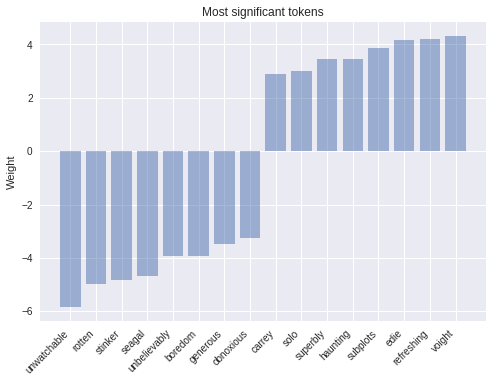

In [8]:
weights = classifier.get_variable_value('linear/linear_model/x/weights').flatten()
sorted_indexes = np.argsort(weights)
extremes = np.concatenate((sorted_indexes[-8:], sorted_indexes[:8]))
extreme_weights = sorted([(weights[i], word_inverted_index[i - index_offset]) for i in extremes])

y_pos = np.arange(len(extreme_weights))
plt.bar(y_pos, [pair[0] for pair in extreme_weights], align='center', alpha=0.5)
plt.xticks(y_pos, [pair[1] for pair in extreme_weights], rotation=45, ha='right')
plt.ylabel('Weight')
plt.title('Most significant tokens') 
plt.show()

As we can see, tokens with the most positive weight such as 'refreshing' are clearly associated with positive sentiment, while tokens that have a large negative weight unarguably evoke negative emotions. A simple but powerful modification that one can do to improve this model is weighting the tokens by their [tf-idf](https://en.wikipedia.org/wiki/Tf%E2%80%93idf) scores.

### Embeddings

The next step of complexity we can add are word embeddings. Embeddings are a dense low-dimensional representation of sparse high-dimensional data. This allows our model to learn a more meaningful representation of each token, rather than just an index. While an individual dimension is not meaningful, the low-dimensional space---when learned from a large enough corpus---has been shown to capture relations such as tense, plural, gender, thematic relatedness, and many more. We can add word embeddings by converting our existing feature column into an `embedding_column`. The representation seen by the model is the mean of the embeddings for each token (see the `combiner` argument in the [docs](https://www.tensorflow.org/api_docs/python/tf/feature_column/embedding_column)). We can plug in the embedded features into a pre-canned `DNNClassifier`. 

A note for the keen observer: an `embedding_column` is just an efficient way of applying a fully connected layer to the sparse binary feature vector of tokens, which is multiplied by a constant depending on the chosen combiner. A direct consequence of this is that it wouldn't make sense to use an `embedding_column` directly in a `LinearClassifier` because two consecutive linear layers without non-linearities in between add no prediction power to the model, unless of course the embeddings are pre-trained.

In [10]:
word_embedding_column = tf.feature_column.embedding_column(column, dimension=embedding_size)
classifier = tf.estimator.DNNClassifier(
    hidden_units=[100],
    feature_columns=[word_embedding_column], 
    model_dir=os.path.join(model_dir, 'bow_embeddings'))
train_and_evaluate(classifier)

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': '/tmp/tmppw5q4h5g/bow_embeddings', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': None, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7ff80ca4bfd0>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/tmppw5q4h5g/bow_embeddings/model.ckpt-25000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving c

INFO:tensorflow:loss = 0.045658894, step = 27101 (0.998 sec)
INFO:tensorflow:global_step/sec: 99.3092
INFO:tensorflow:loss = 0.09517508, step = 27201 (1.011 sec)
INFO:tensorflow:global_step/sec: 93.8945
INFO:tensorflow:loss = 0.07953494, step = 27301 (1.061 sec)
INFO:tensorflow:global_step/sec: 98.8071
INFO:tensorflow:loss = 0.099557295, step = 27401 (1.013 sec)
INFO:tensorflow:global_step/sec: 94.8515
INFO:tensorflow:loss = 0.061936226, step = 27501 (1.059 sec)
INFO:tensorflow:global_step/sec: 100.831
INFO:tensorflow:loss = 0.095372066, step = 27601 (0.987 sec)
INFO:tensorflow:global_step/sec: 99.868
INFO:tensorflow:loss = 0.03764773, step = 27701 (1.006 sec)
INFO:tensorflow:global_step/sec: 95.4445
INFO:tensorflow:loss = 0.040500928, step = 27801 (1.048 sec)
INFO:tensorflow:global_step/sec: 99.249
INFO:tensorflow:loss = 0.06622554, step = 27901 (1.002 sec)
INFO:tensorflow:global_step/sec: 94.1029
INFO:tensorflow:loss = 0.056300994, step = 28001 (1.065 sec)
INFO:tensorflow:global_step

INFO:tensorflow:loss = 0.07047826, step = 30201 (0.980 sec)
INFO:tensorflow:global_step/sec: 94.2099
INFO:tensorflow:loss = 0.045549534, step = 30301 (1.063 sec)
INFO:tensorflow:global_step/sec: 101.291
INFO:tensorflow:loss = 0.09926451, step = 30401 (0.986 sec)
INFO:tensorflow:global_step/sec: 93.7017
INFO:tensorflow:loss = 0.054343674, step = 30501 (1.065 sec)
INFO:tensorflow:global_step/sec: 97.4725
INFO:tensorflow:loss = 0.054645516, step = 30601 (1.028 sec)
INFO:tensorflow:global_step/sec: 100.938
INFO:tensorflow:loss = 0.08584002, step = 30701 (0.992 sec)
INFO:tensorflow:global_step/sec: 95.7977
INFO:tensorflow:loss = 0.0620655, step = 30801 (1.041 sec)
INFO:tensorflow:global_step/sec: 99.6724
INFO:tensorflow:loss = 0.029489601, step = 30901 (1.006 sec)
INFO:tensorflow:global_step/sec: 94.2172
INFO:tensorflow:loss = 0.066843644, step = 31001 (1.060 sec)
INFO:tensorflow:global_step/sec: 98.0702
INFO:tensorflow:loss = 0.056237966, step = 31101 (1.020 sec)
INFO:tensorflow:global_ste

INFO:tensorflow:loss = 0.04991393, step = 33301 (1.037 sec)
INFO:tensorflow:global_step/sec: 101.512
INFO:tensorflow:loss = 0.039790466, step = 33401 (0.986 sec)
INFO:tensorflow:global_step/sec: 95.5779
INFO:tensorflow:loss = 0.052124687, step = 33501 (1.048 sec)
INFO:tensorflow:global_step/sec: 100.234
INFO:tensorflow:loss = 0.041813612, step = 33601 (0.997 sec)
INFO:tensorflow:global_step/sec: 99.2156
INFO:tensorflow:loss = 0.036760665, step = 33701 (1.007 sec)
INFO:tensorflow:global_step/sec: 95.2788
INFO:tensorflow:loss = 0.03418507, step = 33801 (1.049 sec)
INFO:tensorflow:global_step/sec: 99.9703
INFO:tensorflow:loss = 0.046955593, step = 33901 (1.009 sec)
INFO:tensorflow:global_step/sec: 93.2368
INFO:tensorflow:loss = 0.048118643, step = 34001 (1.065 sec)
INFO:tensorflow:global_step/sec: 100.661
INFO:tensorflow:loss = 0.061699595, step = 34101 (0.994 sec)
INFO:tensorflow:global_step/sec: 98.5398
INFO:tensorflow:loss = 0.051889192, step = 34201 (1.015 sec)
INFO:tensorflow:global_

INFO:tensorflow:loss = 0.07621821, step = 36401 (1.000 sec)
INFO:tensorflow:global_step/sec: 94.2352
INFO:tensorflow:loss = 0.057586245, step = 36501 (1.061 sec)
INFO:tensorflow:global_step/sec: 99.6285
INFO:tensorflow:loss = 0.039539207, step = 36601 (1.004 sec)
INFO:tensorflow:global_step/sec: 99.7903
INFO:tensorflow:loss = 0.050203506, step = 36701 (1.002 sec)
INFO:tensorflow:global_step/sec: 92.7856
INFO:tensorflow:loss = 0.045206547, step = 36801 (1.080 sec)
INFO:tensorflow:global_step/sec: 100.293
INFO:tensorflow:loss = 0.06018275, step = 36901 (0.991 sec)
INFO:tensorflow:global_step/sec: 95.0199
INFO:tensorflow:loss = 0.0402413, step = 37001 (1.056 sec)
INFO:tensorflow:global_step/sec: 101.418
INFO:tensorflow:loss = 0.043738816, step = 37101 (0.988 sec)
INFO:tensorflow:global_step/sec: 99.7579
INFO:tensorflow:loss = 0.030885488, step = 37201 (0.997 sec)
INFO:tensorflow:global_step/sec: 94.1272
INFO:tensorflow:loss = 0.03215975, step = 37301 (1.068 sec)
INFO:tensorflow:global_ste

INFO:tensorflow:loss = 0.025799021, step = 39501 (1.057 sec)
INFO:tensorflow:global_step/sec: 99.0096
INFO:tensorflow:loss = 0.056290396, step = 39601 (1.004 sec)
INFO:tensorflow:global_step/sec: 99.9974
INFO:tensorflow:loss = 0.05371637, step = 39701 (1.004 sec)
INFO:tensorflow:global_step/sec: 93.0135
INFO:tensorflow:loss = 0.035072632, step = 39801 (1.075 sec)
INFO:tensorflow:global_step/sec: 100.797
INFO:tensorflow:loss = 0.029252332, step = 39901 (0.989 sec)
INFO:tensorflow:global_step/sec: 95.4597
INFO:tensorflow:loss = 0.031878807, step = 40001 (1.052 sec)
INFO:tensorflow:global_step/sec: 99.8659
INFO:tensorflow:loss = 0.045441344, step = 40101 (1.003 sec)
INFO:tensorflow:global_step/sec: 101.689
INFO:tensorflow:loss = 0.026312578, step = 40201 (0.979 sec)
INFO:tensorflow:global_step/sec: 94.6024
INFO:tensorflow:loss = 0.0328867, step = 40301 (1.057 sec)
INFO:tensorflow:global_step/sec: 99.5765
INFO:tensorflow:loss = 0.030684112, step = 40401 (1.005 sec)
INFO:tensorflow:global_s

INFO:tensorflow:loss = 0.037339523, step = 42601 (1.003 sec)
INFO:tensorflow:global_step/sec: 99.2127
INFO:tensorflow:loss = 0.044002313, step = 42701 (1.003 sec)
INFO:tensorflow:global_step/sec: 94.9194
INFO:tensorflow:loss = 0.034873765, step = 42801 (1.057 sec)
INFO:tensorflow:global_step/sec: 97.3845
INFO:tensorflow:loss = 0.025328917, step = 42901 (1.028 sec)
INFO:tensorflow:global_step/sec: 93.6151
INFO:tensorflow:loss = 0.026125748, step = 43001 (1.070 sec)
INFO:tensorflow:global_step/sec: 97.9726
INFO:tensorflow:loss = 0.039671328, step = 43101 (1.019 sec)
INFO:tensorflow:global_step/sec: 98.5708
INFO:tensorflow:loss = 0.035398558, step = 43201 (1.013 sec)
INFO:tensorflow:global_step/sec: 94.9185
INFO:tensorflow:loss = 0.023641437, step = 43301 (1.055 sec)
INFO:tensorflow:global_step/sec: 98.6153
INFO:tensorflow:loss = 0.038740825, step = 43401 (1.011 sec)
INFO:tensorflow:global_step/sec: 93.5678
INFO:tensorflow:loss = 0.022191186, step = 43501 (1.068 sec)
INFO:tensorflow:globa

INFO:tensorflow:loss = 0.03548154, step = 45701 (1.008 sec)
INFO:tensorflow:global_step/sec: 95.7904
INFO:tensorflow:loss = 0.047826275, step = 45801 (1.044 sec)
INFO:tensorflow:global_step/sec: 98.8466
INFO:tensorflow:loss = 0.040291924, step = 45901 (1.012 sec)
INFO:tensorflow:global_step/sec: 93.3045
INFO:tensorflow:loss = 0.022673763, step = 46001 (1.072 sec)
INFO:tensorflow:global_step/sec: 100.95
INFO:tensorflow:loss = 0.05041736, step = 46101 (0.990 sec)
INFO:tensorflow:global_step/sec: 99.2801
INFO:tensorflow:loss = 0.033098143, step = 46201 (1.007 sec)
INFO:tensorflow:global_step/sec: 96.1888
INFO:tensorflow:loss = 0.022827202, step = 46301 (1.042 sec)
INFO:tensorflow:global_step/sec: 99.7233
INFO:tensorflow:loss = 0.01079429, step = 46401 (1.001 sec)
INFO:tensorflow:global_step/sec: 92.3168
INFO:tensorflow:loss = 0.03702905, step = 46501 (1.083 sec)
INFO:tensorflow:global_step/sec: 101.053
INFO:tensorflow:loss = 0.015336064, step = 46601 (0.988 sec)
INFO:tensorflow:global_ste

INFO:tensorflow:loss = 0.03677236, step = 48801 (1.072 sec)
INFO:tensorflow:global_step/sec: 98.3783
INFO:tensorflow:loss = 0.046143167, step = 48901 (1.018 sec)
INFO:tensorflow:global_step/sec: 92.8336
INFO:tensorflow:loss = 0.036993146, step = 49001 (1.080 sec)
INFO:tensorflow:global_step/sec: 100.582
INFO:tensorflow:loss = 0.033099025, step = 49101 (0.994 sec)
INFO:tensorflow:global_step/sec: 100.966
INFO:tensorflow:loss = 0.025964916, step = 49201 (0.988 sec)
INFO:tensorflow:global_step/sec: 93.3765
INFO:tensorflow:loss = 0.03626041, step = 49301 (1.070 sec)
INFO:tensorflow:global_step/sec: 101.554
INFO:tensorflow:loss = 0.03224695, step = 49401 (0.986 sec)
INFO:tensorflow:global_step/sec: 94.9531
INFO:tensorflow:loss = 0.026801202, step = 49501 (1.053 sec)
INFO:tensorflow:global_step/sec: 99.1612
INFO:tensorflow:loss = 0.019797357, step = 49601 (1.008 sec)
INFO:tensorflow:global_step/sec: 101.157
INFO:tensorflow:loss = 0.014868869, step = 49701 (0.984 sec)
INFO:tensorflow:global_s

We can use TensorBoard to visualize our $50$-dimensional word vectors projected into $\mathbb{R}^3$ using [t-SNE](https://en.wikipedia.org/wiki/T-distributed_stochastic_neighbor_embedding). We expect similar word to be close to each other. This can be a useful way to inspect our model weights and find unexpected behaviours. There's plenty of more information to go deeper [here](https://www.tensorflow.org/programmers_guide/embedding). The following snippet will generate a vocabulary file `metadata.tsv` that lists all the tokens in order. In the **PROJECTOR** tab in *TensorBoard* you can load it to visualize your vectors and there's also the [standalone projector visualizer](http://projector.tensorflow.org) that can be used to check out different embeddings.

![Embedding image](https://github.com/eisenjulian/nlp_estimator_tutorial/blob/master/embeddings.gif?raw=true)

In [0]:
with open(os.path.join(model_dir, 'metadata.tsv'), 'w', encoding="utf-8") as f:
    f.write('label\n')
    for index in range(-index_offset + 1, vocab_size - index_offset + 1):
        f.write(word_inverted_index[index] + '\n')

### Convolutions

At this point one possible approach would be to go deeper, further adding more fully connected layers and playing around with layer sizes and training functions. However, by doing that we would add extra complexity and ignore important structure in our sentences. Words do not live in a vacuum and meaning is compositional, formed by words and its neighbors.

Convolutions are one way to take advantage of this structure, similar to how we can model salient clusters of pixels for [image classification](https://www.tensorflow.org/tutorials/layers). The intuition is that certain sequences of words, or *n-grams*, usually have the same meaning regardless of their overall position in the sentence. Introducing a structural prior via the convolution operation allows us to model the interaction between neighboring words and consequently gives us a better way to represent such meaning.

### Creating a custom estimator

The `tf.estimator` framework provides a higher level API for training machine learning models, defining `train()`, `evaluate()` and `predict()` operations, handling checkpointing, loading, initializing, serving, building the graph and the session out of the box. One the many benefits it provides is that the same code will be able to run in CPUs, GPUs and even in a distributed setup. There's a small family of pre-made estimators, like the ones we used earlier, but it's most likely that you will need to build your own. [This](https://www.tensorflow.org/extend/estimators) guide contains a thorough explanation on how to do it.

We will use a `Head` to simplify the writing of our model function `model_fn`. The head already knows how to compute predictions, loss, train_op, metrics and export outputs, and can be reused across models. We will use `binary_classification_head`, which is a head for single label binary classification that uses `sigmoid_cross_entropy_with_logits` loss.

The model presented here is a port from [this example](https://github.com/keras-team/keras/blob/master/examples/imdb_cnn.py) into the `Estimator` API.

In [12]:
head = tf.contrib.estimator.binary_classification_head()

def cnn_model_fn(features, labels, mode, params):    
    input_layer = tf.contrib.layers.embed_sequence(
        features['x'], vocab_size, embedding_size,
        initializer=params['embedding_initializer'])
    
    training = mode == tf.estimator.ModeKeys.TRAIN
    dropout_emb = tf.layers.dropout(inputs=input_layer, 
                                    rate=0.2, 
                                    training=training)

    conv = tf.layers.conv1d(
        inputs=dropout_emb,
        filters=32,
        kernel_size=3,
        padding="same",
        activation=tf.nn.relu)
    
    # Global Max Pooling
    pool = tf.reduce_max(input_tensor=conv, axis=1)
    
    hidden = tf.layers.dense(inputs=pool, units=250, activation=tf.nn.relu)
    
    dropout_hidden = tf.layers.dropout(inputs=hidden, 
                                       rate=0.2, 
                                       training=training)
    
    logits = tf.layers.dense(inputs=dropout_hidden, units=1)
    
    # This will be None when predicting
    if labels is not None:
        labels = tf.reshape(labels, [-1, 1])
        

    optimizer = tf.train.AdamOptimizer()
    
    def _train_op_fn(loss):
        return optimizer.minimize(
            loss=loss,
            global_step=tf.train.get_global_step())

    return head.create_estimator_spec(
        features=features,
        labels=labels,
        mode=mode,
        logits=logits, 
        train_op_fn=_train_op_fn)
  
params = {'embedding_initializer': tf.random_uniform_initializer(-1.0, 1.0)}
cnn_classifier = tf.estimator.Estimator(model_fn=cnn_model_fn,
                                        model_dir=os.path.join(model_dir, 'cnn'),
                                        params=params)

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': '/tmp/tmppw5q4h5g/cnn', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': None, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7ff80d143470>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


In [13]:
train_and_evaluate(cnn_classifier)

INFO:tensorflow:Calling model_fn.
Instructions for updating:
`NHWC` for data_format is deprecated, use `NWC` instead
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 1 into /tmp/tmppw5q4h5g/cnn/model.ckpt.
INFO:tensorflow:loss = 71.00276, step = 1
INFO:tensorflow:global_step/sec: 131.247
INFO:tensorflow:loss = 70.4605, step = 101 (0.763 sec)
INFO:tensorflow:global_step/sec: 142.61
INFO:tensorflow:loss = 60.6081, step = 201 (0.703 sec)
INFO:tensorflow:global_step/sec: 139.916
INFO:tensorflow:loss = 51.375065, step = 301 (0.716 sec)
INFO:tensorflow:global_step/sec: 144.106
INFO:tensorflow:loss = 54.94073, step = 401 (0.696 sec)
INFO:tensorflow:global_step/sec: 137.382
INFO:tensorflow:loss = 36.194225, step = 501 (0.727 sec)
INFO:tensorflow:global_step/sec: 142.764
INFO:tensorflow:loss = 32.856915, 

INFO:tensorflow:global_step/sec: 142.515
INFO:tensorflow:loss = 22.105951, step = 2601 (0.693 sec)
INFO:tensorflow:global_step/sec: 142.432
INFO:tensorflow:loss = 26.981665, step = 2701 (0.706 sec)
INFO:tensorflow:global_step/sec: 128.306
INFO:tensorflow:loss = 15.109493, step = 2801 (0.777 sec)
INFO:tensorflow:global_step/sec: 143.983
INFO:tensorflow:loss = 19.818504, step = 2901 (0.695 sec)
INFO:tensorflow:global_step/sec: 135.463
INFO:tensorflow:loss = 16.703423, step = 3001 (0.739 sec)
INFO:tensorflow:global_step/sec: 144.705
INFO:tensorflow:loss = 11.5601225, step = 3101 (0.697 sec)
INFO:tensorflow:global_step/sec: 138.846
INFO:tensorflow:loss = 16.464888, step = 3201 (0.717 sec)
INFO:tensorflow:global_step/sec: 132.074
INFO:tensorflow:loss = 9.508666, step = 3301 (0.756 sec)
INFO:tensorflow:global_step/sec: 143.006
INFO:tensorflow:loss = 29.020666, step = 3401 (0.699 sec)
INFO:tensorflow:global_step/sec: 130.12
INFO:tensorflow:loss = 13.530551, step = 3501 (0.767 sec)
INFO:tensor

INFO:tensorflow:loss = 14.459528, step = 5701 (0.711 sec)
INFO:tensorflow:global_step/sec: 131.582
INFO:tensorflow:loss = 10.683574, step = 5801 (0.761 sec)
INFO:tensorflow:global_step/sec: 141.846
INFO:tensorflow:loss = 13.597704, step = 5901 (0.702 sec)
INFO:tensorflow:global_step/sec: 133.455
INFO:tensorflow:loss = 8.665482, step = 6001 (0.751 sec)
INFO:tensorflow:global_step/sec: 142.382
INFO:tensorflow:loss = 12.834925, step = 6101 (0.704 sec)
INFO:tensorflow:global_step/sec: 144.705
INFO:tensorflow:loss = 5.7017503, step = 6201 (0.689 sec)
INFO:tensorflow:global_step/sec: 129.761
INFO:tensorflow:loss = 13.748979, step = 6301 (0.772 sec)
INFO:tensorflow:global_step/sec: 141.517
INFO:tensorflow:loss = 8.34773, step = 6401 (0.705 sec)
INFO:tensorflow:global_step/sec: 130.999
INFO:tensorflow:loss = 21.367388, step = 6501 (0.766 sec)
INFO:tensorflow:global_step/sec: 144.152
INFO:tensorflow:loss = 7.3519006, step = 6601 (0.695 sec)
INFO:tensorflow:global_step/sec: 141.56
INFO:tensorflo

INFO:tensorflow:global_step/sec: 143.552
INFO:tensorflow:loss = 4.8809814, step = 8901 (0.699 sec)
INFO:tensorflow:global_step/sec: 131.184
INFO:tensorflow:loss = 3.7983847, step = 9001 (0.764 sec)
INFO:tensorflow:global_step/sec: 143.198
INFO:tensorflow:loss = 2.1459122, step = 9101 (0.699 sec)
INFO:tensorflow:global_step/sec: 143.496
INFO:tensorflow:loss = 7.8990154, step = 9201 (0.697 sec)
INFO:tensorflow:global_step/sec: 130.354
INFO:tensorflow:loss = 2.3313699, step = 9301 (0.768 sec)
INFO:tensorflow:global_step/sec: 141.814
INFO:tensorflow:loss = 5.4683466, step = 9401 (0.704 sec)
INFO:tensorflow:global_step/sec: 129.437
INFO:tensorflow:loss = 7.235301, step = 9501 (0.771 sec)
INFO:tensorflow:global_step/sec: 144.667
INFO:tensorflow:loss = 5.264308, step = 9601 (0.691 sec)
INFO:tensorflow:global_step/sec: 142.952
INFO:tensorflow:loss = 6.0005836, step = 9701 (0.700 sec)
INFO:tensorflow:global_step/sec: 132.833
INFO:tensorflow:loss = 5.7096004, step = 9801 (0.752 sec)
INFO:tensorf

INFO:tensorflow:loss = 2.8199995, step = 12001 (0.765 sec)
INFO:tensorflow:global_step/sec: 142.567
INFO:tensorflow:loss = 2.3412971, step = 12101 (0.701 sec)
INFO:tensorflow:global_step/sec: 141.496
INFO:tensorflow:loss = 2.495934, step = 12201 (0.706 sec)
INFO:tensorflow:global_step/sec: 132.133
INFO:tensorflow:loss = 4.003313, step = 12301 (0.763 sec)
INFO:tensorflow:global_step/sec: 140.433
INFO:tensorflow:loss = 3.3302722, step = 12401 (0.706 sec)
INFO:tensorflow:global_step/sec: 132.325
INFO:tensorflow:loss = 2.2496274, step = 12501 (0.757 sec)
INFO:tensorflow:global_step/sec: 142.474
INFO:tensorflow:loss = 5.928902, step = 12601 (0.702 sec)
INFO:tensorflow:global_step/sec: 143.898
INFO:tensorflow:loss = 1.9211568, step = 12701 (0.695 sec)
INFO:tensorflow:global_step/sec: 132.925
INFO:tensorflow:loss = 8.313526, step = 12801 (0.753 sec)
INFO:tensorflow:global_step/sec: 141.512
INFO:tensorflow:loss = 7.007321, step = 12901 (0.704 sec)
INFO:tensorflow:global_step/sec: 132.276
INFO:

INFO:tensorflow:loss = 0.7465215, step = 15101 (0.703 sec)
INFO:tensorflow:global_step/sec: 142.912
INFO:tensorflow:loss = 4.4158926, step = 15201 (0.700 sec)
INFO:tensorflow:global_step/sec: 133.474
INFO:tensorflow:loss = 1.6503565, step = 15301 (0.747 sec)
INFO:tensorflow:global_step/sec: 139.868
INFO:tensorflow:loss = 3.512095, step = 15401 (0.716 sec)
INFO:tensorflow:global_step/sec: 130.768
INFO:tensorflow:loss = 0.54446685, step = 15501 (0.765 sec)
INFO:tensorflow:global_step/sec: 138.041
INFO:tensorflow:loss = 8.183871, step = 15601 (0.724 sec)
INFO:tensorflow:global_step/sec: 145.05
INFO:tensorflow:loss = 1.1360481, step = 15701 (0.687 sec)
INFO:tensorflow:global_step/sec: 129.385
INFO:tensorflow:loss = 1.0725486, step = 15801 (0.776 sec)
INFO:tensorflow:global_step/sec: 145.299
INFO:tensorflow:loss = 2.489804, step = 15901 (0.689 sec)
INFO:tensorflow:global_step/sec: 134.499
INFO:tensorflow:loss = 2.422391, step = 16001 (0.744 sec)
INFO:tensorflow:global_step/sec: 140.322
INFO

INFO:tensorflow:loss = 0.9214001, step = 18201 (0.714 sec)
INFO:tensorflow:global_step/sec: 135.378
INFO:tensorflow:loss = 3.4166985, step = 18301 (0.740 sec)
INFO:tensorflow:global_step/sec: 147.175
INFO:tensorflow:loss = 5.8715305, step = 18401 (0.676 sec)
INFO:tensorflow:global_step/sec: 132.168
INFO:tensorflow:loss = 1.6303307, step = 18501 (0.759 sec)
INFO:tensorflow:global_step/sec: 143.379
INFO:tensorflow:loss = 0.2981727, step = 18601 (0.698 sec)
INFO:tensorflow:global_step/sec: 136.011
INFO:tensorflow:loss = 0.9209101, step = 18701 (0.734 sec)
INFO:tensorflow:global_step/sec: 132.419
INFO:tensorflow:loss = 3.7313564, step = 18801 (0.755 sec)
INFO:tensorflow:global_step/sec: 142.633
INFO:tensorflow:loss = 0.19481394, step = 18901 (0.702 sec)
INFO:tensorflow:global_step/sec: 130.875
INFO:tensorflow:loss = 1.690991, step = 19001 (0.759 sec)
INFO:tensorflow:global_step/sec: 141.94
INFO:tensorflow:loss = 4.5606117, step = 19101 (0.705 sec)
INFO:tensorflow:global_step/sec: 141.255
I

INFO:tensorflow:loss = 4.2388797, step = 21301 (0.749 sec)
INFO:tensorflow:global_step/sec: 144.049
INFO:tensorflow:loss = 3.5011063, step = 21401 (0.692 sec)
INFO:tensorflow:global_step/sec: 132.815
INFO:tensorflow:loss = 0.77983075, step = 21501 (0.752 sec)
INFO:tensorflow:global_step/sec: 139.289
INFO:tensorflow:loss = 11.005305, step = 21601 (0.717 sec)
INFO:tensorflow:global_step/sec: 141.116
INFO:tensorflow:loss = 1.6729821, step = 21701 (0.710 sec)
INFO:tensorflow:global_step/sec: 132.783
INFO:tensorflow:loss = 0.12548988, step = 21801 (0.754 sec)
INFO:tensorflow:global_step/sec: 143.661
INFO:tensorflow:loss = 2.0530326, step = 21901 (0.696 sec)
INFO:tensorflow:global_step/sec: 131.285
INFO:tensorflow:loss = 4.871589, step = 22001 (0.761 sec)
INFO:tensorflow:global_step/sec: 141.074
INFO:tensorflow:loss = 1.0553699, step = 22101 (0.707 sec)
INFO:tensorflow:global_step/sec: 143.315
INFO:tensorflow:loss = 7.012484, step = 22201 (0.700 sec)
INFO:tensorflow:global_step/sec: 129.814


INFO:tensorflow:loss = 3.4670062, step = 24401 (0.706 sec)
INFO:tensorflow:global_step/sec: 129.737
INFO:tensorflow:loss = 0.9063788, step = 24501 (0.769 sec)
INFO:tensorflow:global_step/sec: 142.487
INFO:tensorflow:loss = 0.22987898, step = 24601 (0.701 sec)
INFO:tensorflow:global_step/sec: 141.662
INFO:tensorflow:loss = 0.07385022, step = 24701 (0.706 sec)
INFO:tensorflow:global_step/sec: 132.783
INFO:tensorflow:loss = 3.4291701, step = 24801 (0.753 sec)
INFO:tensorflow:global_step/sec: 142.372
INFO:tensorflow:loss = 5.764145, step = 24901 (0.703 sec)
INFO:tensorflow:Saving checkpoints for 25000 into /tmp/tmppw5q4h5g/cnn/model.ckpt.
INFO:tensorflow:Loss for final step: 0.7629983.
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2018-03-06-17:01:33
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/tmppw5q4h5g/cnn/model.ckpt-25000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done 

### LSTM Networks

Using the `Estimator` API and the same model `head`, we can also create a classifier that uses a *Long Short-Term Memory* (*LSTM*) cell instead of convolutions. Recurrent models such as this are some of the most successful building blocks for NLP applications. An LSTM processes the entire document sequentially, recursing over the sequence with its cell while storing the current state of the sequence in its memory.

One of the drawbacks of recurrent models compared to CNNs is that, because of the nature of recursion, models are deeper and more complex, which usually results in slower training time and worse convergence. LSTMs (and RNNs in general) can suffer convergence issues like vanishing or exploding gradients. Having said that, with sufficient tuning they obtain state-of-the-art results for many problems. As a rule of thumb, CNNs are good at feature extraction, while RNNs excel at tasks that depend on the meaning of the whole sentence, like question answering or machine translation.

Each cell processes one token embedding at a time updating its internal state based on a differentiable computation that depends on both the embedding vector $x_t$ and the previous state $h_{t-1}$. In order to get a better understanding of how LSTMs work, you can refer to Chris Olah’s [blog post](https://colah.github.io/posts/2015-08-Understanding-LSTMs/).

![LSTM Architecture](https://colah.github.io/posts/2015-08-Understanding-LSTMs/img/LSTM3-chain.png)
<small><p align="center">
Source: <a href="https://colah.github.io/posts/2015-08-Understanding-LSTMs/">Understanding LSTM Networks</a> by <strong>Chris Olah</strong>
</p></small>

In the beginning of this notebook, we padded all documents up to $200$ tokens, which is necessary to build a proper tensor. However, when a document contains fewer than $200$ words, we don't want the LSTM to continue processing padding tokens as it does not add information and degrades performance. For this reason, we additionally want to provide our network with the length of the original sequence before it was padded. Internally, the model then copies the last state through to the sequence's end. We can do this by using the `"len"` feature in our input functions. We can now use the same logic as above and simply replace the convolutional, pooling, and flatten layers with our LSTM cell.

We can use the same logic as above and simply need to replace the convolutional, pooling, and flatten layers with our LSTM cell.

In [18]:
head = tf.contrib.estimator.binary_classification_head()

def lstm_model_fn(features, labels, mode):    
    # [batch_size x sentence_size x embedding_size]
    inputs = tf.contrib.layers.embed_sequence(
        features['x'], vocab_size, embedding_size,
        initializer=tf.random_uniform_initializer(-1.0, 1.0))

    # create an LSTM cell of size 100
    lstm_cell = tf.nn.rnn_cell.BasicLSTMCell(100)
    
    # create the complete LSTM
    _, final_states = tf.nn.dynamic_rnn(
        lstm_cell, inputs, sequence_length=features['len'], dtype=tf.float32)

    # get the final hidden states of dimensionality [batch_size x sentence_size]
    outputs = final_states.h

    logits = tf.layers.dense(inputs=outputs, units=1)

    # This will be None when predicting
    if labels is not None:
        labels = tf.reshape(labels, [-1, 1])

    optimizer = tf.train.AdamOptimizer()

    def _train_op_fn(loss):
        return optimizer.minimize(
            loss=loss,
            global_step=tf.train.get_global_step())

    return head.create_estimator_spec(
        features=features,
        labels=labels,
        mode=mode,
        logits=logits,
        train_op_fn=_train_op_fn)


lstm_classifier = tf.estimator.Estimator(model_fn=lstm_model_fn,
                                         model_dir=os.path.join(model_dir, 'lstm'))
train_and_evaluate(lstm_classifier)

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': '/tmp/tmpypwz2ae9/lstm', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': None, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7ff12e45a0b8>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/tmpypwz2ae9/lstm/model.ckpt-24338
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 24339

### Pretrained vectors

Most of the models that we have shown before rely on word embeddings as a first layer, and we have so far initialized this embedding layer randomly, however it has been shown [in](https://arxiv.org/abs/1607.01759) [the](https://arxiv.org/abs/1301.3781) [literature](https://arxiv.org/abs/1103.0398), that especially for small labelled datasets, it is beneficial to train a pretrain word embeddings on a large unlabelled corpora using an unsupervised task. One such task is shown [here](https://www.tensorflow.org/tutorials/word2vec). This technique is an instance of *transfer learning*.

To this end, we will show you how to use them in an `Estimator`. We will use the pre-trained vectors from another popular model, [GloVe](https://nlp.stanford.edu/projects/glove/).

We download the pretrained vectors and define a function that loads them into a `numpy.array`.

In [14]:
if not os.path.exists('glove.6B.zip'):
    ! wget http://nlp.stanford.edu/data/glove.6B.zip
if not os.path.exists('glove.6B.50d.txt'):
    ! unzip glove.6B.zip

--2018-03-06 17:01:38--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2018-03-06 17:01:38--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glove.6B.zip         48%[========>           ] 397.21M  4.85MB/s    eta 32s    

glove.6B.zip        100%[===================>] 822.24M  11.9MB/s    in 93s     

2018-03-06 17:03:11 (8.88 MB/s) - ‘glove.6B.zip’ saved [862182613/862182613]

Archive:  glove.6B.zip
  inflating: glove.6B.50d.txt        
  inflating: glove.6B.100d.txt       
  inflating: glove.6B.200d.txt       
  inflating: glove.6B.300d.txt       


In [15]:
def load_glove_embeddings(path):
    embeddings = {}
    with open(path, 'r', encoding='utf-8') as f:
        for line in f:
            values = line.strip().split()
            w = values[0]
            vectors = np.asarray(values[1:], dtype='float32')
            embeddings[w] = vectors

    embedding_matrix = np.random.uniform(-1, 1, size=(vocab_size, embedding_size))
    num_loaded = 0
    for w, i in word_index.items():
        v = embeddings.get(w)
        if v is not None and i < vocab_size:
            embedding_matrix[i] = v
            num_loaded += 1
    print('Successfully loaded pretrained embeddings for '
          f'{num_loaded}/{vocab_size} words.')
    embedding_matrix = embedding_matrix.astype(np.float32)
    return embedding_matrix

embedding_matrix = load_glove_embeddings('glove.6B.50d.txt')

Successfully loaded pretrained embeddings for 4920/5000 words.


To create a CNN classifier that leverages pretrained embeddings, we can reuse our `cnn_model_fn` but pass in a custom initializer that initializes the embeddings with our pretrained embedding matrix.

In [16]:
def my_initializer(shape=None, dtype=tf.float32, partition_info=None):
    assert dtype is tf.float32
    return embedding_matrix

params = {'embedding_initializer': my_initializer}
cnn_pretrained_classifier = tf.estimator.Estimator(model_fn=cnn_model_fn,
                                        model_dir=os.path.join(model_dir, 'cnn_pretrained'),
                                        params=params)
train_and_evaluate(cnn_pretrained_classifier)

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': '/tmp/tmppw5q4h5g/cnn_pretrained', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': None, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7ff7fa967a58>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 1 into /tmp/tmppw5q4h5g/cnn_pretrained/model.ckpt.
INFO:tensorflow:loss = 76

INFO:tensorflow:loss = 28.029745, step = 2201 (0.747 sec)
INFO:tensorflow:global_step/sec: 122.326
INFO:tensorflow:loss = 27.09712, step = 2301 (0.815 sec)
INFO:tensorflow:global_step/sec: 133.161
INFO:tensorflow:loss = 35.560253, step = 2401 (0.751 sec)
INFO:tensorflow:global_step/sec: 125.566
INFO:tensorflow:loss = 23.276848, step = 2501 (0.794 sec)
INFO:tensorflow:global_step/sec: 132.372
INFO:tensorflow:loss = 16.987421, step = 2601 (0.760 sec)
INFO:tensorflow:global_step/sec: 135.813
INFO:tensorflow:loss = 15.646078, step = 2701 (0.736 sec)
INFO:tensorflow:global_step/sec: 124.599
INFO:tensorflow:loss = 11.777176, step = 2801 (0.800 sec)
INFO:tensorflow:global_step/sec: 134.424
INFO:tensorflow:loss = 32.319553, step = 2901 (0.744 sec)
INFO:tensorflow:global_step/sec: 124.247
INFO:tensorflow:loss = 16.529232, step = 3001 (0.807 sec)
INFO:tensorflow:global_step/sec: 134.814
INFO:tensorflow:loss = 17.815783, step = 3101 (0.741 sec)
INFO:tensorflow:global_step/sec: 133.891
INFO:tensor

INFO:tensorflow:global_step/sec: 136.882
INFO:tensorflow:loss = 16.323835, step = 5401 (0.731 sec)
INFO:tensorflow:global_step/sec: 124.5
INFO:tensorflow:loss = 6.9232507, step = 5501 (0.806 sec)
INFO:tensorflow:global_step/sec: 134.229
INFO:tensorflow:loss = 7.9834127, step = 5601 (0.743 sec)
INFO:tensorflow:global_step/sec: 134.866
INFO:tensorflow:loss = 11.070493, step = 5701 (0.740 sec)
INFO:tensorflow:global_step/sec: 124.151
INFO:tensorflow:loss = 7.0646567, step = 5801 (0.806 sec)
INFO:tensorflow:global_step/sec: 137.071
INFO:tensorflow:loss = 6.431694, step = 5901 (0.729 sec)
INFO:tensorflow:global_step/sec: 124.528
INFO:tensorflow:loss = 6.797315, step = 6001 (0.806 sec)
INFO:tensorflow:global_step/sec: 135.017
INFO:tensorflow:loss = 8.136586, step = 6101 (0.737 sec)
INFO:tensorflow:global_step/sec: 135.519
INFO:tensorflow:loss = 6.2746034, step = 6201 (0.739 sec)
INFO:tensorflow:global_step/sec: 125.731
INFO:tensorflow:loss = 14.237473, step = 6301 (0.800 sec)
INFO:tensorflow

INFO:tensorflow:loss = 11.992082, step = 8501 (0.808 sec)
INFO:tensorflow:global_step/sec: 135.913
INFO:tensorflow:loss = 8.3349, step = 8601 (0.737 sec)
INFO:tensorflow:global_step/sec: 136.869
INFO:tensorflow:loss = 8.206715, step = 8701 (0.731 sec)
INFO:tensorflow:global_step/sec: 127.457
INFO:tensorflow:loss = 4.276661, step = 8801 (0.784 sec)
INFO:tensorflow:global_step/sec: 135.664
INFO:tensorflow:loss = 11.074739, step = 8901 (0.738 sec)
INFO:tensorflow:global_step/sec: 126.115
INFO:tensorflow:loss = 11.588633, step = 9001 (0.791 sec)
INFO:tensorflow:global_step/sec: 137.675
INFO:tensorflow:loss = 0.9723448, step = 9101 (0.727 sec)
INFO:tensorflow:global_step/sec: 134.551
INFO:tensorflow:loss = 5.3092785, step = 9201 (0.743 sec)
INFO:tensorflow:global_step/sec: 124.945
INFO:tensorflow:loss = 4.391673, step = 9301 (0.796 sec)
INFO:tensorflow:global_step/sec: 137.624
INFO:tensorflow:loss = 5.2582364, step = 9401 (0.727 sec)
INFO:tensorflow:global_step/sec: 127.502
INFO:tensorflow:

INFO:tensorflow:global_step/sec: 136.73
INFO:tensorflow:loss = 3.6423123, step = 11701 (0.733 sec)
INFO:tensorflow:global_step/sec: 127.396
INFO:tensorflow:loss = 2.3514652, step = 11801 (0.783 sec)
INFO:tensorflow:global_step/sec: 133.625
INFO:tensorflow:loss = 4.343174, step = 11901 (0.750 sec)
INFO:tensorflow:global_step/sec: 125.111
INFO:tensorflow:loss = 2.2058659, step = 12001 (0.797 sec)
INFO:tensorflow:global_step/sec: 135.9
INFO:tensorflow:loss = 3.4984634, step = 12101 (0.738 sec)
INFO:tensorflow:global_step/sec: 135.198
INFO:tensorflow:loss = 2.4561772, step = 12201 (0.738 sec)
INFO:tensorflow:global_step/sec: 125.754
INFO:tensorflow:loss = 3.783059, step = 12301 (0.797 sec)
INFO:tensorflow:global_step/sec: 135.454
INFO:tensorflow:loss = 6.8978195, step = 12401 (0.734 sec)
INFO:tensorflow:global_step/sec: 127.712
INFO:tensorflow:loss = 2.7153256, step = 12501 (0.785 sec)
INFO:tensorflow:global_step/sec: 134.13
INFO:tensorflow:loss = 0.87610674, step = 12601 (0.749 sec)
INFO:

INFO:tensorflow:global_step/sec: 126.877
INFO:tensorflow:loss = 0.6925531, step = 14801 (0.787 sec)
INFO:tensorflow:global_step/sec: 135.772
INFO:tensorflow:loss = 0.6080221, step = 14901 (0.737 sec)
INFO:tensorflow:global_step/sec: 127.521
INFO:tensorflow:loss = 1.2456927, step = 15001 (0.785 sec)
INFO:tensorflow:global_step/sec: 136.846
INFO:tensorflow:loss = 0.39504007, step = 15101 (0.729 sec)
INFO:tensorflow:global_step/sec: 136.111
INFO:tensorflow:loss = 2.9151976, step = 15201 (0.735 sec)
INFO:tensorflow:global_step/sec: 123.753
INFO:tensorflow:loss = 2.1115937, step = 15301 (0.804 sec)
INFO:tensorflow:global_step/sec: 135.961
INFO:tensorflow:loss = 1.3160815, step = 15401 (0.740 sec)
INFO:tensorflow:global_step/sec: 125.893
INFO:tensorflow:loss = 1.967402, step = 15501 (0.792 sec)
INFO:tensorflow:global_step/sec: 137.401
INFO:tensorflow:loss = 10.011297, step = 15601 (0.729 sec)
INFO:tensorflow:global_step/sec: 136.463
INFO:tensorflow:loss = 6.830148, step = 15701 (0.732 sec)
I

INFO:tensorflow:global_step/sec: 137.556
INFO:tensorflow:loss = 0.4283558, step = 17901 (0.726 sec)
INFO:tensorflow:global_step/sec: 125.006
INFO:tensorflow:loss = 0.8747641, step = 18001 (0.797 sec)
INFO:tensorflow:global_step/sec: 137.344
INFO:tensorflow:loss = 0.39599264, step = 18101 (0.735 sec)
INFO:tensorflow:global_step/sec: 135.639
INFO:tensorflow:loss = 1.3521464, step = 18201 (0.735 sec)
INFO:tensorflow:global_step/sec: 125.639
INFO:tensorflow:loss = 4.2518077, step = 18301 (0.796 sec)
INFO:tensorflow:global_step/sec: 137.027
INFO:tensorflow:loss = 0.3902916, step = 18401 (0.731 sec)
INFO:tensorflow:global_step/sec: 127.288
INFO:tensorflow:loss = 1.9845206, step = 18501 (0.783 sec)
INFO:tensorflow:global_step/sec: 136.972
INFO:tensorflow:loss = 1.4177113, step = 18601 (0.730 sec)
INFO:tensorflow:global_step/sec: 137.563
INFO:tensorflow:loss = 0.26515934, step = 18701 (0.723 sec)
INFO:tensorflow:global_step/sec: 127.805
INFO:tensorflow:loss = 1.8354334, step = 18801 (0.787 sec

INFO:tensorflow:global_step/sec: 123.279
INFO:tensorflow:loss = 1.1768968, step = 21001 (0.805 sec)
INFO:tensorflow:global_step/sec: 135.699
INFO:tensorflow:loss = 0.4111416, step = 21101 (0.739 sec)
INFO:tensorflow:global_step/sec: 137.784
INFO:tensorflow:loss = 1.3886865, step = 21201 (0.726 sec)
INFO:tensorflow:global_step/sec: 128.29
INFO:tensorflow:loss = 3.1211743, step = 21301 (0.776 sec)
INFO:tensorflow:global_step/sec: 135.878
INFO:tensorflow:loss = 1.3276843, step = 21401 (0.739 sec)
INFO:tensorflow:global_step/sec: 126.715
INFO:tensorflow:loss = 0.22026868, step = 21501 (0.789 sec)
INFO:tensorflow:global_step/sec: 137.269
INFO:tensorflow:loss = 0.8374204, step = 21601 (0.728 sec)
INFO:tensorflow:global_step/sec: 135.05
INFO:tensorflow:loss = 1.6549548, step = 21701 (0.740 sec)
INFO:tensorflow:global_step/sec: 127.661
INFO:tensorflow:loss = 0.29935893, step = 21801 (0.781 sec)
INFO:tensorflow:global_step/sec: 135.496
INFO:tensorflow:loss = 0.33687344, step = 21901 (0.739 sec)

INFO:tensorflow:global_step/sec: 136.503
INFO:tensorflow:loss = 0.29781562, step = 24101 (0.733 sec)
INFO:tensorflow:global_step/sec: 136.639
INFO:tensorflow:loss = 3.680334, step = 24201 (0.733 sec)
INFO:tensorflow:global_step/sec: 128.384
INFO:tensorflow:loss = 0.81191015, step = 24301 (0.778 sec)
INFO:tensorflow:global_step/sec: 136.141
INFO:tensorflow:loss = 1.0568783, step = 24401 (0.733 sec)
INFO:tensorflow:global_step/sec: 126.553
INFO:tensorflow:loss = 0.30457726, step = 24501 (0.792 sec)
INFO:tensorflow:global_step/sec: 138.148
INFO:tensorflow:loss = 0.19197173, step = 24601 (0.724 sec)
INFO:tensorflow:global_step/sec: 138.53
INFO:tensorflow:loss = 0.20814349, step = 24701 (0.722 sec)
INFO:tensorflow:global_step/sec: 127.845
INFO:tensorflow:loss = 1.7888054, step = 24801 (0.778 sec)
INFO:tensorflow:global_step/sec: 135.584
INFO:tensorflow:loss = 3.1667922, step = 24901 (0.743 sec)
INFO:tensorflow:Saving checkpoints for 25000 into /tmp/tmppw5q4h5g/cnn_pretrained/model.ckpt.
INF

## Results

### Launching TensorBoard

Now we can launch TensorBoard and see how the different models we've trained compare against each other in terms of training time and performance.

In a terminal, do
```bash
> tensorboard --logdir={model_dir}
```

We can visualize many metrics collected while training and testing, including the loss function values of each model at each training step, and the precision-recall curves. This is of course most useful to select which model works best for our use-case as well as how to choose classification thresholds.

![PR curve](https://raw.githubusercontent.com/eisenjulian/nlp_estimator_tutorial/master/pr_curves.png) 

![loss](https://raw.githubusercontent.com/eisenjulian/nlp_estimator_tutorial/master/loss.png)


### Getting Predictions

To get predictions on new sentences we can use the `predict` method in the `Estimator` instances, which will load the latest checkpoint for each model and evaluate on the unseen examples. But before passing the data into the model we have to clean up, tokenize and map each token to the corresponding index, as shown here.

It's worth noting that the checkpoint itelf is not enough to make predictions since the actual code used to build the estimator is necessary as well, in order to map the saved weights into the corresponding tensors, so it's a good practice associate saved checkpoints with the branch of code with which they were created.

If your are interested in exporting the models to disk in a fully recoverable way you might want to look into the [SavedModel](https://www.tensorflow.org/programmers_guide/saved_model#using_savedmodel_with_estimators) class, specially useful for serving your model through an API using [TensorFlow Serving](https://github.com/tensorflow/serving).

In [17]:
def text_to_index(sentence):
    # Remove punctuation characters except for the apostrophe
    translator = str.maketrans('', '', string.punctuation.replace("'", ''))
    tokens = sentence.translate(translator).lower().split()
    return np.array([1] + [word_index[t] + index_offset if t in word_index else 2 for t in tokens])

def print_predictions(sentences):
    indexes = [text_to_index(sentence) for sentence in sentences]
    x = sequence.pad_sequences(indexes, 
                               maxlen=sentence_size, 
                               padding='post', 
                               value=-1)
    length = np.array([min(len(x), sentence_size) for x in indexes])
    predict_input_fn = tf.estimator.inputs.numpy_input_fn(x={"x": x, "len": length}, shuffle=False)
    predictions = {}
    for path, classifier in all_classifiers.items():
        predictions[path] = [p['logistic'][0] for p in classifier.predict(input_fn=predict_input_fn)]
    for idx, sentence in enumerate(sentences):
        print(sentence)
        for path in all_classifiers:
            print("\t{} {}".format(path, predictions[path][idx]))
            
print_predictions([
    'I really liked the movie!',
    'Hated every second of it...'])

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/tmppw5q4h5g/bow_sparse/model.ckpt-25000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/tmppw5q4h5g/bow_embeddings/model.ckpt-50000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/tmppw5q4h5g/cnn/model.ckpt-25000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/tmppw5

### Other resources

In this notebook, we explored how to use estimators for text classification, in particular for the IMDB Reviews Dataset. We trained and visualized our own embeddings, as well as loaded pre-trained ones. We started from a simple baseline and made our way to convolutional neural networks and LSTMs.

For more details, be sure to check out:

 * The complete [source code](https://github.com) for this blog post.
 * A [Jupyter notebook](https://github.com) that can run locally, or on Colaboratory.
 * The TensorFlow [Embedding](https://www.tensorflow.org/programmers_guide/embedding) guide.
 * The TensorFlow [Vector Representation of Words](https://www.tensorflow.org/tutorials/word2vec) tutorial.
 * The *NLTK* [Processing Raw Text](http://www.nltk.org/book/ch03.html) chapter on how to design langage pipelines.
 
In a following tutorial, we will show how to build a model using eager execution, work with out-of-memory datasets, train in Cloud ML, and deploy with TensorFlow Serving.


----------

*Thanks for reading! If you like you can find us online at [ruder.io](http://ruder.io/) and [@eisenjulian](https://twitter.com/eisenjulian). Send our way all your feedback and questions.*